## Отберём картинки (выберем 1 породу)

In [1]:
import os
def get_base_name(filename):
    name_part, _ = os.path.splitext(filename)

    parts = name_part.split('_')

    base_parts = []
    for part in parts:
        if part.isdigit():
            break
        base_parts.append(part)

    base_name = '_'.join(base_parts)

    return base_name

In [2]:
dataset_path = 'datasets/oxford'

In [8]:
image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith('.jpg')]
chosen_class = get_base_name(image_files[0])
image_paths = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.lower().endswith('.jpg') and get_base_name(f) == chosen_class]

## Введём параметры и сделаем загрузчики

In [50]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

from torchvision.utils import save_image


IMG_SIZE=256


EPOCHS = 1000

BATCH_SIZE=30
LEARNING_RATE=0.0002
B1=0.5
B2=0.999
LATENT_DIM=100
CHANNELS=3
OUTPUT_DIR=f'GAN_{IMG_SIZE}'

In [51]:
os.makedirs(f'{OUTPUT_DIR}', exist_ok=True)

In [52]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

image_transformation = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_dataset = CustomDataset(image_paths, transform=image_transformation)

data_loader = DataLoader(image_dataset, batch_size=BATCH_SIZE, shuffle=True)

img_shape = (CHANNELS, IMG_SIZE, IMG_SIZE)

cuda_is_present = True

## Объявляем модели:

In [53]:
class Generator(nn.Module):
	def __init__(self):
		super().__init__()

		def layer_block(input_size, output_size, normalize=True):
			layers = [nn.Linear(input_size, output_size)]
			if normalize:
				layers.append(nn.BatchNorm1d(output_size, 0.8))
			layers.append(nn.LeakyReLU(0.2, inplace=True))
			return layers

		self.model = nn.Sequential(
			*layer_block(LATENT_DIM, 128, normalize=False),
			*layer_block(128, 256),
			*layer_block(256, 512),
			*layer_block(512, 1024),
			nn.Linear(1024, int(np.prod(img_shape))),
			nn.Tanh()
		)

	def forward(self, z):
		img = self.model(z)
		img = img.view(img.size(0), *img_shape)
		return img

class Discriminator(nn.Module):
	def __init__(self):
		super().__init__()

		self.model = nn.Sequential(
			nn.Linear(int(np.prod(img_shape)), 512),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Linear(512, 256),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Linear(256, 1),
			nn.Sigmoid()
		)

	def forward(self, img):
		img_flat = img.view(img.size(0), -1)
		verdict = self.model(img_flat)
		return verdict

generator = Generator()
discriminator = Discriminator()
adversarial_loss = torch.nn.BCELoss()

if cuda_is_present:
	generator.cuda()
	discriminator.cuda()
	adversarial_loss.cuda()

Tensor = torch.cuda.FloatTensor if cuda_is_present else torch.FloatTensor

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(B1, B2))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(B1, B2))

## Обучаем

[Epoch    1/1000] [Batch    0/7] ---> [D Loss: 0.718574] [G Loss: 0.651379]
[Epoch    1/1000] [Batch    1/7] ---> [D Loss: 7.182347] [G Loss: 0.659394]
[Epoch    1/1000] [Batch    2/7] ---> [D Loss: 1.043075] [G Loss: 0.639398]
[Epoch    1/1000] [Batch    3/7] ---> [D Loss: 0.651738] [G Loss: 0.616169]
[Epoch    1/1000] [Batch    4/7] ---> [D Loss: 0.386527] [G Loss: 0.629334]
[Epoch    1/1000] [Batch    5/7] ---> [D Loss: 0.431965] [G Loss: 0.666688]
[Epoch    1/1000] [Batch    6/7] ---> [D Loss: 0.375365] [G Loss: 0.663371]
[Epoch    2/1000] [Batch    0/7] ---> [D Loss: 0.351488] [G Loss: 0.687006]
[Epoch    2/1000] [Batch    1/7] ---> [D Loss: 0.322522] [G Loss: 0.748484]
[Epoch    2/1000] [Batch    2/7] ---> [D Loss: 0.285545] [G Loss: 0.841476]
[Epoch    2/1000] [Batch    3/7] ---> [D Loss: 0.242174] [G Loss: 0.963709]
[Epoch    2/1000] [Batch    4/7] ---> [D Loss: 0.299283] [G Loss: 1.122216]
[Epoch    2/1000] [Batch    5/7] ---> [D Loss: 0.528846] [G Loss: 0.460646]
[Epoch    2/

C:\Users\Maxim\AppData\Local\Temp\ipykernel_6376\3221478547.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images_for_gif.append(imageio.imread(image_filename))


[Epoch   11/1000] [Batch    0/7] ---> [D Loss: 0.875943] [G Loss: 0.192298]
[Epoch   11/1000] [Batch    1/7] ---> [D Loss: 0.966747] [G Loss: 0.157606]
[Epoch   11/1000] [Batch    2/7] ---> [D Loss: 0.666066] [G Loss: 0.306867]
[Epoch   11/1000] [Batch    3/7] ---> [D Loss: 0.397653] [G Loss: 0.600557]
[Epoch   11/1000] [Batch    4/7] ---> [D Loss: 0.636848] [G Loss: 1.045074]
[Epoch   11/1000] [Batch    5/7] ---> [D Loss: 0.858433] [G Loss: 0.198834]
[Epoch   11/1000] [Batch    6/7] ---> [D Loss: 1.025344] [G Loss: 0.138682]
[Epoch   12/1000] [Batch    0/7] ---> [D Loss: 0.860833] [G Loss: 0.198130]
[Epoch   12/1000] [Batch    1/7] ---> [D Loss: 0.592895] [G Loss: 0.365182]
[Epoch   12/1000] [Batch    2/7] ---> [D Loss: 0.389962] [G Loss: 0.613342]
[Epoch   12/1000] [Batch    3/7] ---> [D Loss: 0.317982] [G Loss: 0.927405]
[Epoch   12/1000] [Batch    4/7] ---> [D Loss: 0.460872] [G Loss: 0.507430]
[Epoch   12/1000] [Batch    5/7] ---> [D Loss: 0.492430] [G Loss: 0.467875]
[Epoch   12/

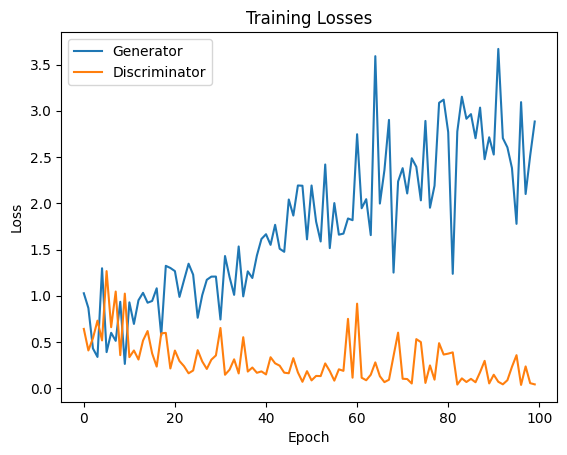

In [54]:
losses = []
images_for_gif = []
for epoch in range(1, EPOCHS+1):
	for i, images in enumerate(data_loader):

		real_images = Variable(images.type(Tensor))
		real_output = Variable(Tensor(images.size(0), 1).fill_(1.0), requires_grad=False)
		fake_output = Variable(Tensor(images.size(0), 1).fill_(0.0), requires_grad=False)

		# Training Generator
		optimizer_generator.zero_grad()
		z = Variable(Tensor(np.random.normal(0, 1, (images.shape[0], LATENT_DIM))))
		generated_images = generator(z)
		generator_loss = adversarial_loss(discriminator(generated_images), real_output)
		generator_loss.backward()
		optimizer_generator.step()

		# Training Discriminator
		optimizer_discriminator.zero_grad()
		discriminator_loss_real = adversarial_loss(discriminator(real_images), real_output)
		discriminator_loss_fake = adversarial_loss(discriminator(generated_images.detach()), fake_output)
		discriminator_loss = (discriminator_loss_real + discriminator_loss_fake) / 2
		discriminator_loss.backward()
		optimizer_discriminator.step()

		print(f"[Epoch {epoch:=4d}/{EPOCHS}] [Batch {i:=4d}/{len(data_loader)}] ---> "
			f"[D Loss: {discriminator_loss.item():.6f}] [G Loss: {generator_loss.item():.6f}]")

	if (epoch%10==0):
		losses.append((generator_loss.item(), discriminator_loss.item()))
		image_filename = f'{OUTPUT_DIR}/{epoch}.png'
		save_image(generated_images.data[:25], image_filename, nrow=5, normalize=True)
		images_for_gif.append(imageio.imread(image_filename))

losses = np.array(losses)
plt.plot(losses.T[0], label='Generator')
plt.plot(losses.T[1], label='Discriminator')
plt.title("Training Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f'{OUTPUT_DIR}/loss_plot.png')

imageio.mimwrite(f'{OUTPUT_DIR}/generated_images.gif', images_for_gif, fps=len(images)/5)
